# HW1P2: Frame-Level Speech Recognition

# Libraries

In [ ]:
!pip install torchsummary wandb --quiet

In [ ]:
!pip install torchaudio --quiet

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchsummary import summary
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torchaudio
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# Mount Google Drive

In [ ]:
''' If you are using colab, you can import google drive to save model checkpoints in a folder
    If you want to use it, uncomment the two lines below
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

In [ ]:
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here

    f.write('{"username":"hy8888","key":"4c3d0c8b26506874f701b0ccc2f494d0"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=198ca861e10b5fa99be71bdc3457165420d768df8216b6b4eab15f932e396bd3
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# commands to download data from kaggle
!kaggle competitions download -c 11785-spring-25-hw-1-p-2

# Unzip downloaded data
!unzip -qo /content/11785-spring-25-hw-1-p-2.zip -d '/content'

# List contents of the input directory
# !ls /kaggle/input/11785-spring-25-hw-1-p-2/
# Check if directory exists
# !find /kaggle/input/11785-spring-25-hw-1-p-2 -type d

100% 3.98G/3.98G [00:16<00:00, 333MB/s]
100% 3.98G/3.98G [00:16<00:00, 254MB/s]


# Parameters Configuration

In [ ]:
config = {
    'Name': 'hy8888', # Write your name here
    'subset': 0.6, # Subset of dataset to use (1.0 == 100% of data)
    'context': 30,
    'archetype': 'pyramid', # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'ReLU', # Opt:GELU
    'learning_rate': 0.001,
    'dropout': 0.3,
    'optimizers': 'AdamW', # Opt: SDG
    'scheduler': 'ReduceLROnPlateau',
    'epochs': 20,
    'batch_size': 512,
    'weight_decay': 0.01,
    'weight_initialization': None, # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8,
 }

In [ ]:
config

{'Name': 'hy8888',
 'subset': 0.6,
 'context': 30,
 'archetype': 'pyramid',
 'activations': 'ReLU',
 'learning_rate': 0.001,
 'dropout': 0.3,
 'optimizers': 'AdamW',
 'scheduler': 'ReduceLROnPlateau',
 'epochs': 30,
 'batch_size': 512,
 'weight_decay': 0.01,
 'weight_initialization': None,
 'augmentations': 'Both',
 'freq_mask_param': 4,
 'time_mask_param': 8}

# Dataset Class

In [ ]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes
        self.subset = config['subset']

        # TODO: Initialize augmentations. Read the Pytorch torchaudio documentations on timemasking and frequencymasking
        self.freq_masking = tat.FrequencyMasking(freq_mask_param=config['time_mask_param'])
        self.time_masking = tat.TimeMasking(time_mask_param=config['freq_mask_param'])


        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir       = os.path.join(root, partition, 'mfcc')
        # TODO: Transcripts directory - use partition to acces train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root, partition, 'transcript')

        # TODO: List files in sefl.mfcc_dir using os.listdir in SORTED order
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))
        # TODO: List files in self.transcript_dir using os.listdir in SORTED order
        transcript_names    = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(mfcc_names))

        # Select subset of data to use
        mfcc_names = mfcc_names[:subset_size]
        transcript_names = transcript_names[:subset_size]

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc             = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            # cepstral normalization == mean normalization
            mfccs_normalized = mfcc - np.mean(mfcc, axis=0)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

            # TODO: Load the corresponding transcript
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript  = np.load(os.path.join(self.transcript_dir, transcript_names[i]))[1:-1]

            # The available phonemes in the transcript are of string data type
            # But the neural network cannot predict strings as such.
            # Hence, we map these phonemes to integers

            # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
            transcript_indices = [self.phonemes.index(p) for p in transcript]
            # Now, if an element in the transcript is 0, it means that it is 'SIL' (as per the above example)

            # Convert transcript to tensor
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)

        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...
        # Each transcript is of shape (T1+2), (T2+2) before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        # Hint: Use torch to concatenate
        self.mfccs          = torch.cat(self.mfccs, dim=0)

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        # Hint: Use torch to concatenate
        self.transcripts    = torch.cat(self.transcripts)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame

        # We can introduce context by padding zeros on top and bottom of self.mfcc
        # Hint: Use torch.nn.functional.pad
        # torch.nn.functional.pad takes the padding in the form of (left, right, top, bottom) for 2D data
        self.mfccs = nn.functional.pad(self.mfccs, (0,0,config['context'],config['context']), mode='constant', value=0)

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs) - 2 * config['context']

    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        start = ind
        end = ind + 2 * config['context'] + 1
        frames = self.mfccs[start:end]

        # To ensure consistent size
        if frames.shape[0] != 2 * config['context'] + 1:
            # Pad if shorter
            needed_padding = (2 * config['context'] + 1) - frames.shape[0]
            frames = torch.nn.functional.pad(frames, (0, 0, 0, needed_padding))

        # After slicing, you get an array of shape 2*context+1 x 28.

        phonemes = self.transcripts[ind]

        return frames, phonemes


In [ ]:
class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "test-clean"):
        self.mfcc_dir       = os.path.join(root, partition, 'mfcc')
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))
        self.mfccs          = []

        for i in tqdm(range(len(mfcc_names))):
            mfcc             = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
            mfccs_normalized = mfcc - np.mean(mfcc, axis=0)
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)
            self.mfccs.append(mfccs_normalized)

        self.mfccs = torch.cat(self.mfccs)
        self.mfccs = nn.functional.pad(self.mfccs, (0,0,config['context'],config['context']), mode='constant', value=0)
        self.length = len(self.mfccs) - 2 * config['context']

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        start = ind
        end = ind + 2 * config['context'] + 1
        frames = self.mfccs[start:end]

        return frames

    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.
    # IMPORTANT: Load complete test data to use, DO NOT select subset of test data, else you will get errors when submitting on Kaggle.

# Create Datasets

In [ ]:
# ROOT = "/kaggle/input/11785-spring-25-hw-1-p-2/11785-s25-hw1p2"
ROOT ="/content/11785-s25-hw1p2" # Define the root directory of the dataset here

# TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(ROOT, partition="train-clean-100")

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(ROOT, partition="dev-clean")

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(ROOT, partition="test-clean")

  0%|          | 0/17123 [00:00<?, ?it/s]

  0%|          | 0/1621 [00:00<?, ?it/s]

  0%|          | 0/2620 [00:00<?, ?it/s]

In [ ]:
# Check
print(f"Train length: {len(train_data)}")
print(f"Val length: {len(val_data)}")
print(f"Test length: {len(test_data)}")
assert len(test_data) == 1934138, "Test length mismatch"

Train length: 21512633
Val length: 1220601
Test length: 1934138


In [ ]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn,
    drop_last=True # to avoid last batch of data incomplete, instead of padding just drop the last batch to maintain the format
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  512
Context        :  30
Input size     :  1708
Output symbols :  42
Train dataset samples = 21512633, batches = 42016
Validation dataset samples = 1220601, batches = 2384
Test dataset samples = 1934138, batches = 3778


torch.Size([512, 61, 28]) torch.Size([512])


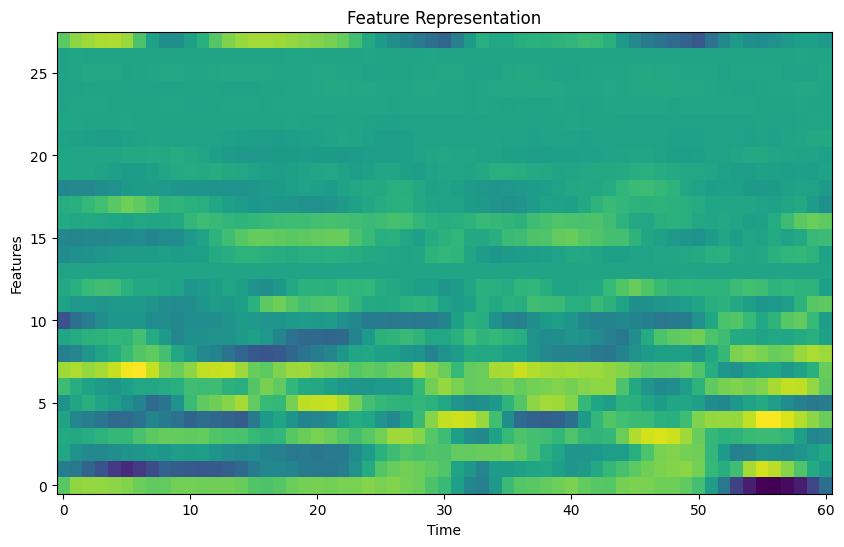

In [ ]:
import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [ ]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

# Network Architecture


In [ ]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
# attempt_5_2

class Network(nn.Module): # INPUTSIZE=(2*config['context']+1)*28)
    def __init__(self, input_size, output_size):
        super(Network, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(config['dropout']),


            nn.Linear(64, output_size)
        )

        if config['weight_initialization'] is not None:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                if config["weight_initialization"] == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                elif config["weight_initialization"] == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                elif config["weight_initialization"] == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "uniform":
                    torch.nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")

                # Initialize bias to 0
                m.bias.data.fill_(0)


    def forward(self, x):

        # Flatten to a 1D vector for each data point
        x = torch.flatten(x, start_dim=1)  # Keeps batch size, flattens the rest

        return self.model(x)

# Define Model, Loss Function and Optimizer

In [ ]:
!nvidia-smi
print("CUDA available:", torch.cuda.is_available())

Thu Feb  6 18:51:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             48W /  400W |     723MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
INPUT_SIZE  = (2*config['context']+1)*28 # Why is this the case? features
# device = 'cuda' if torch.cuda.is_available() else 'cpu' # try cpu first
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device).cuda()
summary(model, frames[0].to(device).shape)
#  Output Shape [-1,,,,] -1 is a placeholder for the batch size
# Check number of parameters of your network
# Remember, you are limited to 20 million parameters for HW1 (including ensembles)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       7,000,064
       BatchNorm1d-2                 [-1, 4096]           8,192
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 2048]       8,390,656
       BatchNorm1d-6                 [-1, 2048]           4,096
              ReLU-7                 [-1, 2048]               0
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 1024]       2,098,176
      BatchNorm1d-10                 [-1, 1024]           2,048
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
      BatchNorm1d-14                  [

# Define Model, Loss Function and Optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

# Choose an appropriate optimizer of your choice
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html
# Mixed Precision Training with AMP for speedup
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Training and Validation Functions

In [ ]:
# CLEAR RAM!!
torch.cuda.empty_cache()
gc.collect()

56

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        # OPTIONAL: You can add gradient clipping here, if you face issues of exploding gradients

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval()
    vloss, vacc = 0, 0
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.no_grad():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

In [ ]:
wandb.login(key="06a27b50be8dd39b3865d8e90bb7c3248eafc168") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hychia2024 (hychia2024-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "Attempt_5_2", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20250206_185111-2o4jgus4/files/model_arch.txt']

In [ ]:
# # Check test_loader format
for batch in test_loader:
    print("Batch shape:", batch.shape)
    # print("Sample values:", batch[0])  # First item
    break
print(len(test_loader))
print(len(val_loader))
print(len(train_loader))
# # Check if dimensions match expected (batch_size, context_frames, features)
expected_shape = (config['batch_size'], 2*config['context']+1, 28)
print("\nExpected shape:", expected_shape)

Batch shape: torch.Size([512, 61, 28])
3778
2384
42016

Expected shape: (512, 61, 28)


# Experiment

In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ## Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr},step=epoch)

    # If using a scheduler, step the learning rate here, otherwise comment this line
    # Depending on the scheduler in use, you may or may not need to pass in a metric into the step function, so read the docs well
    scheduler.step(val_acc)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc
    }, f'checkpoint_epoch_{epoch}.pt')
    wandb.save(f'checkpoint_epoch_{epoch}.pt')
    print("Saved checkpoint")

    ## Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best

In [ ]:
# Load your checkpoint
checkpoint_path = '/checkpoint_epoch_18.pt'  # saved path
checkpoint = torch.load(checkpoint_path, weights_only=True)

# Verify the epoch and accuracy
print(f"Checkpoint from epoch: {checkpoint['epoch']}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Load model state
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

Checkpoint from epoch: 18
Validation accuracy: 0.82%


Network(
  (model): Sequential(
    (0): Linear(in_features=1708, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tr

# Testing and submission to Kaggle

In [ ]:
wandb.init(project="hw1p2", name="submit_attempt_5_2", settings=wandb.Settings(init_timeout=180))

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=config['batch_size'],
    num_workers=0,  # Reduced from 2
    pin_memory=True,
    shuffle=False
)

In [ ]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.no_grad(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_indices = torch.argmax(logits, dim=1) #Label: The predicted label of the phoneme [0-39] (The Phoneme).

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # Remember the phonemes were converted to their corresponding integer indices earlier, and the results of the argmax is a list of the indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes
            # TODO: Store predicted_phonemes
            predicted_phonemes = [PHONEMES[idx] for idx in predicted_indices.cpu().numpy()]

            test_predictions.extend(predicted_phonemes)

    return test_predictions

In [ ]:
predictions = test(model, test_loader)

  0%|          | 0/3778 [00:00<?, ?it/s]

In [ ]:
# Check model
print("Model in memory:", 'model' in locals() or 'model' in globals())

# Check data loaders
print("Data loaders:", 'train_loader' in locals(), 'val_loader' in locals())

# Check device
print("Device:", 'device' in locals())

Model in memory: True
Data loaders: True True
Device: True


In [ ]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,Label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [ ]:
### Finish your wandb run
run.finish()

In [ ]:
print(f"Test dataset length: {len(test_data)}")

Test dataset length: 1934138


In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-spring-25-hw-1-p-2 -f /content/submission.csv -m "Submission_attempt_5_2"

### However, its always safer to download the csv file and then upload to kaggle

100% 19.3M/19.3M [00:00<00:00, 22.4MB/s]
Successfully submitted to 11785_Spring25_HW1P2